In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Data exploration and cleaning

In [61]:
df = pd.read_csv('./data/Loan_Data.csv') # data frame imported

In [62]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [63]:
df.columns # better view of the columns names

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [64]:
df1 = df.copy() # making a copy of data frame

In [65]:
df1 = df1.rename(columns={'CoapplicantIncome': 'Coapplicant_Income','ApplicantIncome': 'Applicant_Income','LoanAmount': 'Loan_Amount'})
df1 = df1.drop('Loan_ID', axis = 1)
df1 # standartizing the columns names, removed LOAN ID row, as I will not use it

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [66]:
df1.dtypes # checking the types of data in columns

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
Applicant_Income        int64
Coapplicant_Income    float64
Loan_Amount           float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
dtype: object

In [67]:
df1.isna().sum() # checking the number of NaN per column

Gender                13
Married                3
Dependents            15
Education              0
Self_Employed         32
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount           22
Loan_Amount_Term      14
Credit_History        50
Property_Area          0
Loan_Status            0
dtype: int64

In [68]:
df1['Credit_History'].value_counts() #checking the content of the column

1.0    475
0.0     89
Name: Credit_History, dtype: int64

Here I decided to drop rows with NaN-values on Credit History, as it is usually one of the most influential parameter for loan-regarding decisions, thus I did not want to risk by guessing it.

In [69]:
df2 = df1.dropna(subset=["Credit_History"]) 
df2.isna().sum()

Gender                12
Married                3
Dependents            15
Education              0
Self_Employed         26
Applicant_Income       0
Coapplicant_Income     0
Loan_Amount           21
Loan_Amount_Term      14
Credit_History         0
Property_Area          0
Loan_Status            0
dtype: int64

In [70]:
df2_numerical = df2.select_dtypes("number") # separating numerical from categorical values
df2_categorical = df2.select_dtypes("object")

In [71]:
for column in df2_categorical.columns: # replasing NaN values in categorical columns with mode
    mode = df2_categorical[column].mode()[0]
    df2_categorical[column].fillna(mode, inplace=True)


In [75]:
df2_categorical

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


In [72]:
 df2_categorical.isna().sum() # NaN values are succesfully filled 

Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
Loan_Status      0
dtype: int64

In [79]:
for column in df2_numerical.columns: # replasing NaN values in NUMERICAL columns with MEAN
    mean = df2_numerical[column].mean()
    df2_numerical[column].fillna(mean, inplace=True)

In [80]:
df2_numerical

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History
0,5849,0,145.088398,360.0,1.0
1,4583,1508,128.000000,360.0,1.0
2,3000,0,66.000000,360.0,1.0
3,2583,2358,120.000000,360.0,1.0
4,6000,0,141.000000,360.0,1.0
...,...,...,...,...,...
609,2900,0,71.000000,360.0,1.0
610,4106,0,40.000000,180.0,1.0
611,8072,240,253.000000,360.0,1.0
612,7583,0,187.000000,360.0,1.0


In [94]:
dot = '.' # Removing uneccessary remainers
def remove_zeroes(x):
    result = round(x)
    return result 

for col in df2_numerical:
    df2_numerical[col] = df2_numerical[col].apply(remove_zeroes)

In [95]:
df2_numerical

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History
0,5849,0,145,360,1
1,4583,1508,128,360,1
2,3000,0,66,360,1
3,2583,2358,120,360,1
4,6000,0,141,360,1
...,...,...,...,...,...
609,2900,0,71,360,1
610,4106,0,40,180,1
611,8072,240,253,360,1
612,7583,0,187,360,1


In [96]:
df2_numerical.isna().sum()

Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Loan_Amount_Term      0
Credit_History        0
dtype: int64

In [97]:
df2 = pd.concat([df2_numerical, df2_categorical], axis=1) # concatinating numerical and categorical parts of dataframe 

In [98]:
df2 # clean data-frame without NaN's

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,5849,0,145,360,1,Male,No,0,Graduate,No,Urban,Y
1,4583,1508,128,360,1,Male,Yes,1,Graduate,No,Rural,N
2,3000,0,66,360,1,Male,Yes,0,Graduate,Yes,Urban,Y
3,2583,2358,120,360,1,Male,Yes,0,Not Graduate,No,Urban,Y
4,6000,0,141,360,1,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0,71,360,1,Female,No,0,Graduate,No,Rural,Y
610,4106,0,40,180,1,Male,Yes,3+,Graduate,No,Rural,Y
611,8072,240,253,360,1,Male,Yes,1,Graduate,No,Urban,Y
612,7583,0,187,360,1,Male,Yes,2,Graduate,No,Urban,Y


In [100]:
df2.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History
count,564.000000,564.000000,564.000000,564.000000,564.000000
mean,5466.436170,1530.448582,145.085106,342.148936,0.842199
std,6271.344106,2471.721411,81.740936,63.778194,0.364878
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2892.750000,0.000000,101.750000,360.000000,1.000000
50%,3815.000000,1105.500000,128.500000,360.000000,1.000000
75%,5803.750000,2250.000000,162.000000,360.000000,1.000000
max,81000.000000,33837.000000,700.000000,480.000000,1.000000


# 2. EDA

In [120]:
type((df2_categorical.columns.get_loc('Gender')+1))

int

Visualising categorigal values

<Axes: xlabel='Credit_History', ylabel='count'>

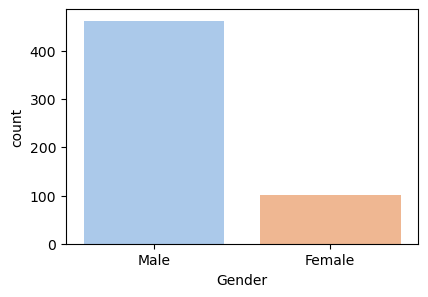

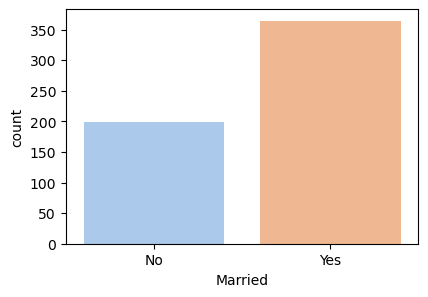

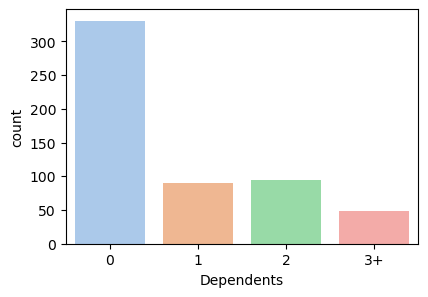

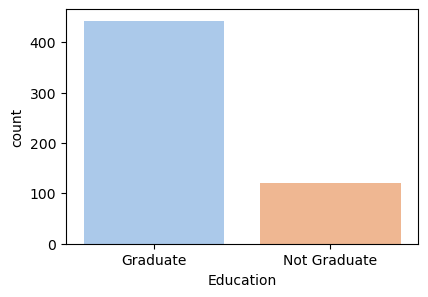

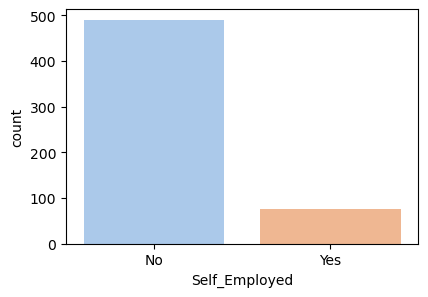

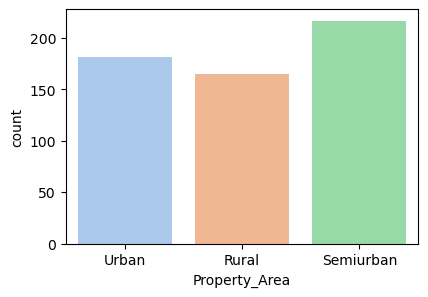

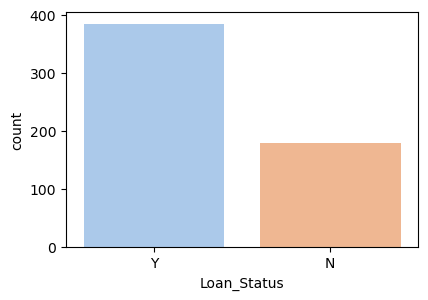

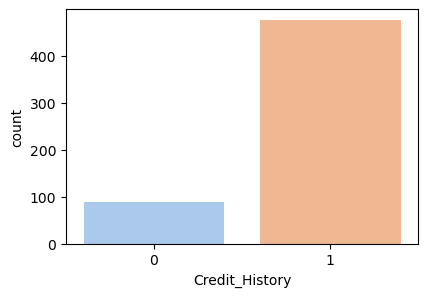

In [132]:
for col in df2_categorical: # visualising categorical columns
    plt.figure(figsize = (10,14))
    plt.subplot(4,2,(df2_categorical.columns.get_loc(col)+1))
    sns.countplot(x = col, palette = 'pastel', data = df2_categorical)
    
plt.figure(figsize = (10,14))
plt.subplot(4,2,8)
sns.countplot(x = 'Credit_History', palette = 'pastel', data = df2_numerical)

Dataset mostly represents Male candidates, married canditates are twice as common, biggest part is not self-employed and have achieved heigher education. More than 50% of population does not have dependants while being nearly equaly spead across three living area types. It is also cleare that we have more than twice amount of 'Y' in Loan_Status over 'N' (our target variable). 

Numerical columns visualization:


<Axes: xlabel='Loan_Amount_Term', ylabel='Count'>

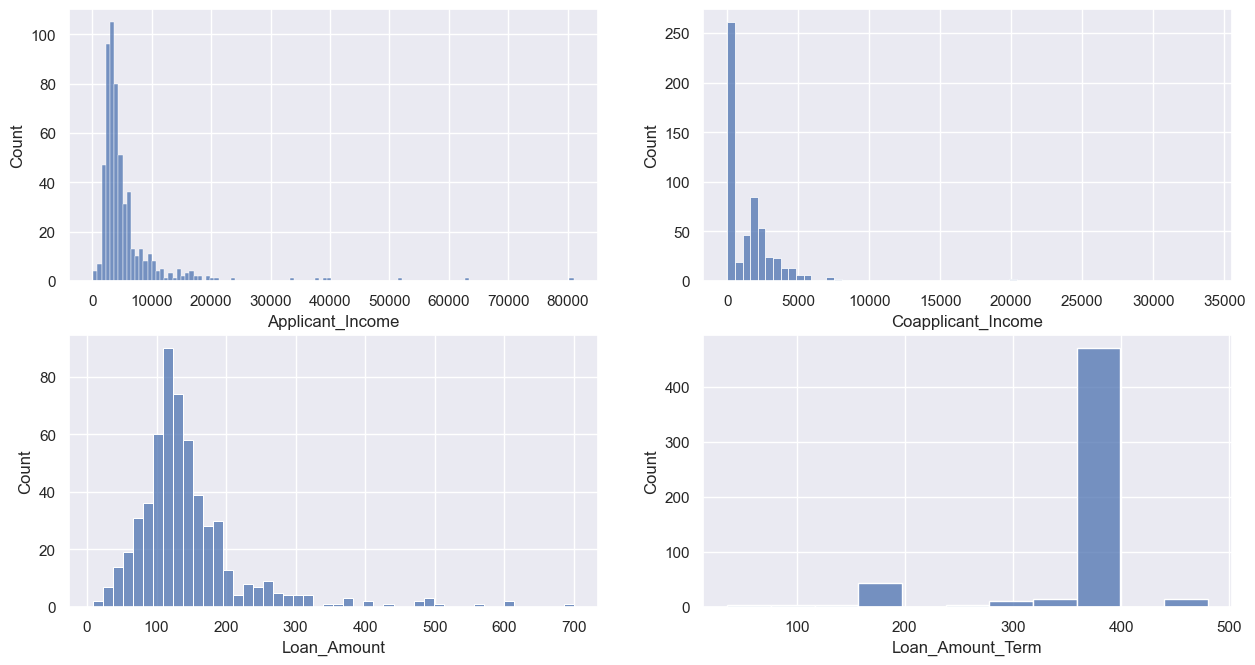

In [142]:
plt.figure(figsize = (15,12))

plt.subplot(3,2,1)
sns.histplot(df2['Applicant_Income'])

plt.subplot(3,2,2)
sns.histplot(df2['Coapplicant_Income'])

plt.subplot(3,2,3)
sns.histplot(df2['Loan_Amount'])

plt.subplot(3,2,4)
sns.histplot(df2['Loan_Amount_Term'])

As visible above, Applicant_Income and Loan_amount both look like a normal distribution, while Coaplocant_Incom has a big amount of outlier (0 value), Loan_Amount_Term has the mode around 400 and distributed differently, as it is still more of a categorical column. One more tendency that is notisable is that the data frame is mostly represented by lower values.

Correlation tables between target variable and categoribal features:

<Axes: xlabel='Credit_History', ylabel='count'>

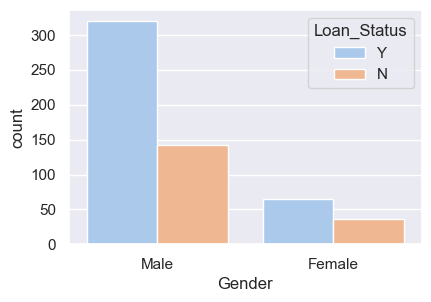

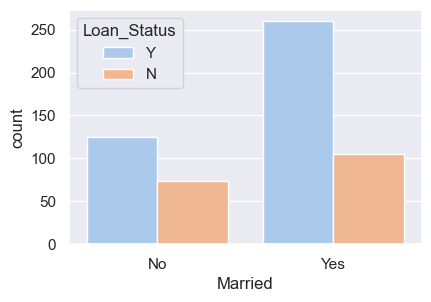

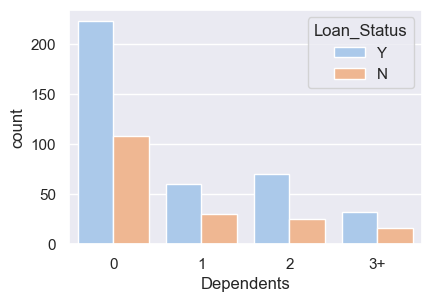

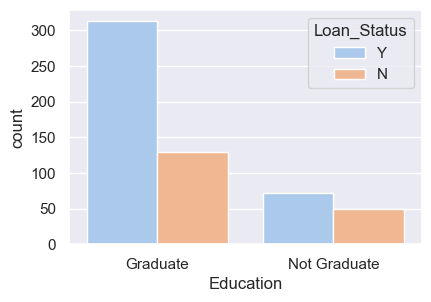

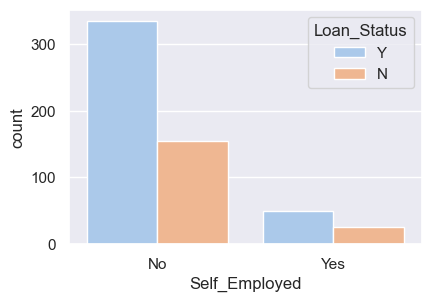

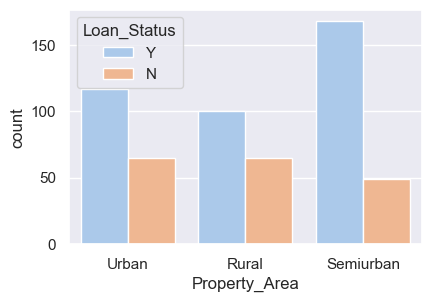

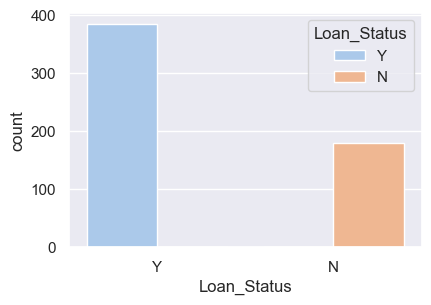

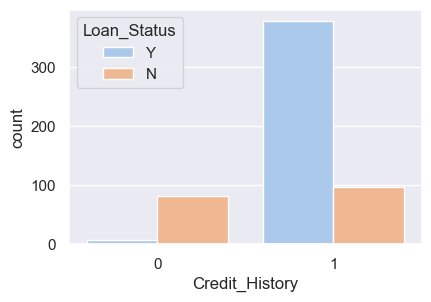

In [144]:
for col in df2_categorical:
    
    plt.figure(figsize = (10,14))
    plt.subplot(4,2,(df2_categorical.columns.get_loc(col)+1))
    sns.countplot(x = col , hue = 'Loan_Status', palette = 'pastel', data = df2)

plt.figure(figsize = (10,14))
plt.subplot(4,2,8)
sns.countplot(x = 'Credit_History' , hue = 'Loan_Status', palette = 'pastel', data = df2)


The only clearly correlated feature to target variable visible is Credit_History. If candidates have credit history - then it is most likely they will receive the loan approval, opose to having no credit history, where, in our data set the amount of aprovals for candidates without credit history is nearly reaching "0".

In [149]:
for col in df2_categorical:  #Contingency table below shows the same but in %  
    
    contingency_table = pd.crosstab(df2[col], df2['Loan_Status'])

    row_sums = contingency_table.sum(axis=1)
    col_sums = contingency_table.sum(axis=0)
    
    contingency_table["Y"] = contingency_table["Y"] / contingency_table["Y"].sum() * 100
    contingency_table["N"] = contingency_table["N"] / contingency_table["N"].sum() * 100


    display(contingency_table)
    
# Credit_History is not in the categorical, that is why I had to make a different code for this varriably
    
contingency_table2 = pd.crosstab(df2['Credit_History'], df2['Loan_Status'])

row_sums = contingency_table2.sum(axis=1)
col_sums = contingency_table2.sum(axis=0)
    
contingency_table2["Y"] = contingency_table2["Y"] / contingency_table2["Y"].sum() * 100
contingency_table2["N"] = contingency_table2["N"] / contingency_table2["N"].sum() * 100


display(contingency_table2)

Loan_Status,N,Y
Gender,,
Female,20.111732,16.883117
Male,79.888268,83.116883


Loan_Status,N,Y
Married,,
No,41.340782,32.467532
Yes,58.659218,67.532468


Loan_Status,N,Y
Dependents,,
0,60.335196,57.922078
1,16.759777,15.584416
2,13.966480,18.181818
3+,8.938547,8.311688


Loan_Status,N,Y
Education,,
Graduate,72.625698,81.298701
Not Graduate,27.374302,18.701299


Loan_Status,N,Y
Self_Employed,,
No,86.03352,87.012987
Yes,13.96648,12.987013


Loan_Status,N,Y
Property_Area,,
Rural,36.312849,25.974026
Semiurban,27.374302,43.636364
Urban,36.312849,30.389610


Loan_Status,N,Y
Loan_Status,,
N,100.0,0.0
Y,0.0,100.0


Loan_Status,N,Y
Credit_History,,
0,45.810056,1.818182
1,54.189944,98.181818


Looking for correlations between continuous varriables and target

C:\Users\Dmitr\AppData\Local\Temp\ipykernel_7112\3026542305.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr(method='pearson')


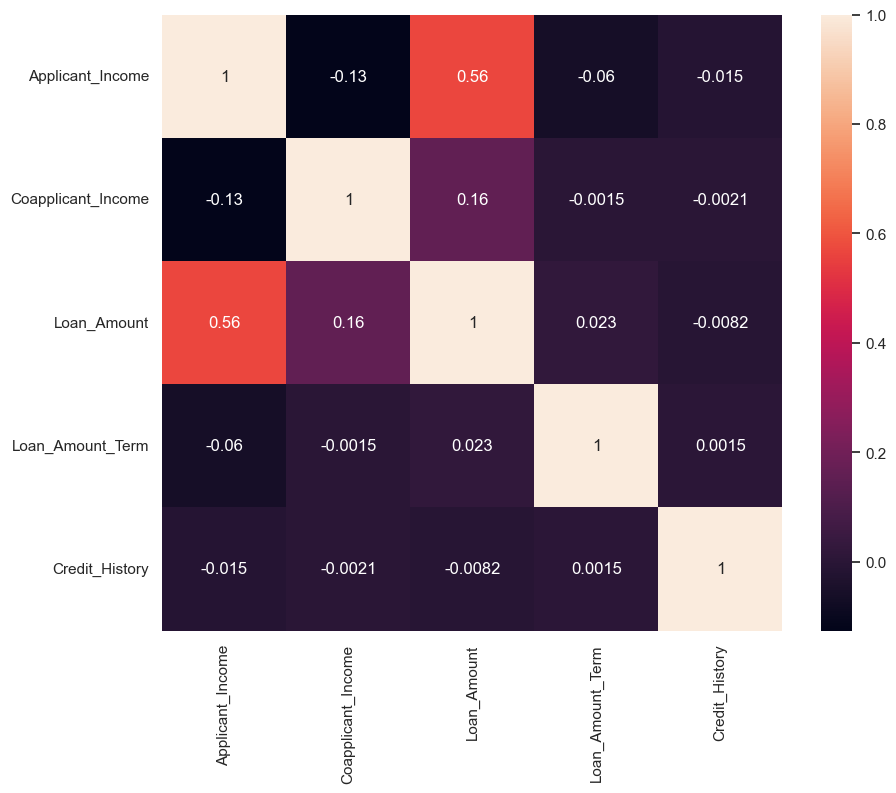

In [150]:
corr_matrix = df2.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

As it is visible from the heat map, there are not strong correlations

In [161]:
# Filtering data frame to see the approved load applications with no credit history
df_filter1 = df2[df2['Credit_History'].isin([0])]
df_filter2 = df_filter1[df_filter1['Loan_Status'].isin(['Y'])]
df_filter2

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
122,2137,8980,137,360,0,Female,No,0,Graduate,No,Semiurban,Y
155,39999,0,600,180,0,Male,Yes,3+,Graduate,No,Semiurban,Y
201,4923,0,166,360,0,Male,No,2,Graduate,No,Semiurban,Y
267,4333,1811,160,360,0,Male,Yes,3+,Graduate,No,Urban,Y
326,4917,0,130,360,0,Male,No,0,Graduate,No,Rural,Y
453,2483,2466,90,180,0,Male,Yes,0,Graduate,No,Rural,Y
527,5285,1430,161,360,0,Male,Yes,1,Not Graduate,No,Semiurban,Y


<Axes: xlabel='Loan_Amount_Term', ylabel='Count'>

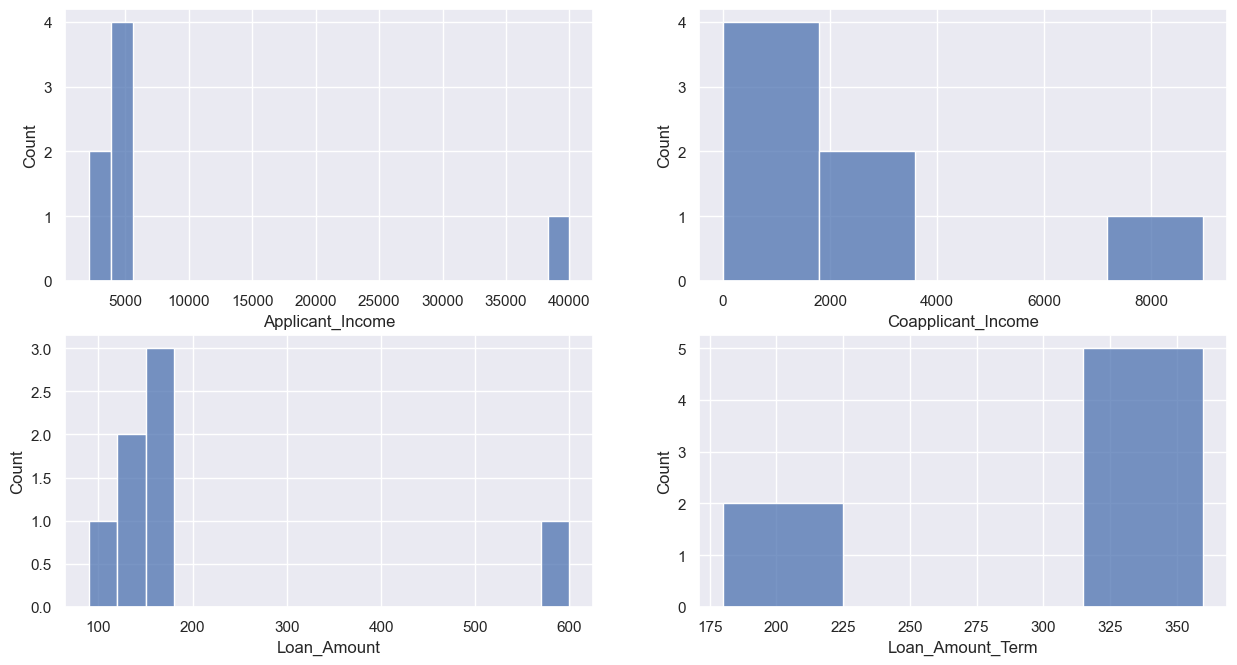

In [162]:
plt.figure(figsize = (15,12))

plt.subplot(3,2,1)
sns.histplot(df_filter2['Applicant_Income'])

plt.subplot(3,2,2)
sns.histplot(df_filter2['Coapplicant_Income'])

plt.subplot(3,2,3)
sns.histplot(df_filter2['Loan_Amount'])

plt.subplot(3,2,4)
sns.histplot(df_filter2['Loan_Amount_Term'])

<Axes: xlabel='Coapplicant_Income'>

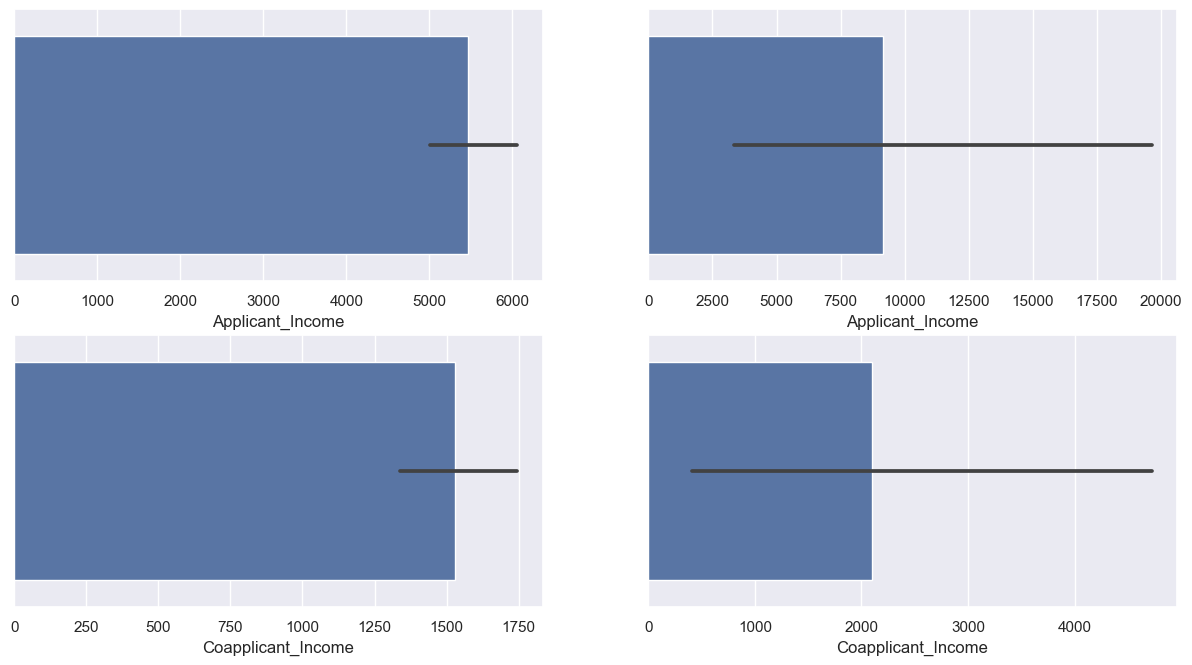

In [175]:
plt.figure(figsize = (15,12))

plt.subplot(3,2,1)
sns.barplot(data=df2, x="Applicant_Income")

plt.subplot(3,2,2)
sns.barplot(data=df_filter2, x="Applicant_Income")

plt.subplot(3,2,3)
sns.barplot(data=df2, x="Coapplicant_Income")

plt.subplot(3,2,4)
sns.barplot(data=df_filter2, x="Coapplicant_Income")

In [191]:
np.mean(df2["Applicant_Income"]) + np.mean(df2["Coapplicant_Income"]) # for the whole sample


6996.88475177305

In [190]:
np.median(df2["Applicant_Income"]) + np.median(df2["Coapplicant_Income"]) # for the whole sample

4920.5

In [186]:
np.mean(df_filter2["Applicant_Income"]) + np.mean(df_filter2["Coapplicant_Income"])  # for the filtered sample

11252.0

In [192]:
np.median(df_filter2["Applicant_Income"]) + np.median(df_filter2["Coapplicant_Income"]) # for the filtered sample

6347.0

From above we can see that the sum of applicant and coapplicant incomes are heigher, when it comes to approved loans without credit history. Meanwhile all the rest variables avarage remain about the same as in initial data set.